## V5

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta

pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Use 3 decimal places in output display
pd.set_option("display.precision", 3)

CATEGORY_FREQ = 50

In [2]:
df_shops = pd.read_csv("shops.csv")
df_shops.describe()

,shop_id
count,60.00000
mean,29.50000
std,17.46425
min,0.00000
25%,14.75000
50%,29.50000
75%,44.25000
max,59.00000


In [3]:
# get valid shop id
def valid_shop_id(id):
    if id == 0:
        return 57
    if id == 1:
        return 58
#    if id == 23:
#        return 24
    if id == 11:
        return 10
    if id == 40:
        return 39 
    return id

def shop_type(shop):
    #types = ['ТК', 'ТЦ', 'ТРК', 'ТРЦ']
    p = re.compile(r"(Т[РКЦ]+)")
    r = p.search(shop)
    if r is not None: return r.group(1) 
    if 'нлайн' in shop: return 'Онлайн'
    if 'нтернет' in shop: return 'Онлайн'
    return 'Магазин'

# get city
def shop_city(shop):
    p = re.compile(r"^([а-яА-Я\.]*)")
    r = p.search(shop)
    if r is not None: return r.group(1) 
    return 'Unknown'

#df_shops['valid_id'] = df_shops['shop_id'] 

In [4]:
df_shops.drop([0,1], inplace=True)

In [5]:
df_shops['city'] = df_shops['shop_name'].apply(lambda x: shop_city(x))
df_shops['type'] = df_shops['shop_name'].apply(lambda x: shop_type(x))
df_shops['mega'] = df_shops['shop_name'].str.contains('мега', case=False).astype(int)

In [6]:
df_shops = df_shops.set_index('shop_id')
df_shops.tail()

,shop_name,city,type,mega
shop_id,,,,
55,Цифровой склад 1С-Онлайн,Цифровой,Онлайн,0
56,"Чехов ТРЦ ""Карнавал""",Чехов,ТРЦ,0
57,"Якутск Орджоникидзе, 56",Якутск,Магазин,0
58,"Якутск ТЦ ""Центральный""",Якутск,ТЦ,0
59,"Ярославль ТЦ ""Альтаир""",Ярославль,ТЦ,0


In [7]:
 df_shops.iloc[25]['type']

'ТЦ'

In [8]:
df_categories = pd.read_csv("item_categories.csv", index_col='item_category_id')
df_categories.describe()

,item_category_name
count,84
unique,84
top,Книги - Аудиокниги 1С
freq,1


In [9]:
df_categories['category'] = df_categories['item_category_name'].str.split('[-(]', n=0).str[0].str.strip()
df_categories['digital'] = df_categories['item_category_name'].str.contains('цифра', case=False).astype(int)

In [10]:
df_categories.index.names = ['category_id']
df_categories.head()

,item_category_name,category,digital
category_id,,,
0,PC - Гарнитуры/Наушники,PC,0
1,Аксессуары - PS2,Аксессуары,0
2,Аксессуары - PS3,Аксессуары,0
3,Аксессуары - PS4,Аксессуары,0
4,Аксессуары - PSP,Аксессуары,0


In [11]:
df_items = pd.read_csv("items.csv", index_col='item_id')
df_items.describe()

,item_category_id
count,22170.00000
mean,46.29075
std,15.94149
min,0.00000
25%,37.00000
50%,40.00000
75%,58.00000
max,83.00000


In [12]:
df_items.head()

,item_name,item_category_id
item_id,,
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40
1,!ABBYY FineReader 12 Professional Edition Full...,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,40
4,***КОРОБКА (СТЕКЛО) D,40


In [13]:
#df_items["label1"] = df_items["item_name"].str.lower().str.extract(r"\((.*?)\)")[0]
df_items["label1"] = df_items["item_name"].str.lower().str.extractall(r"\((.*?)\)")[0].str.split(',').groupby(level=0).apply(lambda l: [item.strip() for sublist in l for item in sublist])
df_items["label2"] = df_items["item_name"].str.lower().str.extractall(r"\[(.*?)\]")[0].str.split(',').groupby(level=0).apply(lambda l: [item.strip() for sublist in l for item in sublist])
#label1 = df_items["label1"].value_counts()
#[print(k) for k in label1.keys() if label1[k] < 2]
df_items[["label1", "label2"]].head(20)

,label1,label2
item_id,,
0,[пласт.],NaN
1,NaN,"[pc, цифровая версия]"
2,[unv],NaN
3,[univ],NaN
4,[стекло],NaN
5,[uni],NaN
6,[uni],NaN
7,[uni],NaN
8,NaN,NaN


In [14]:
label_corrections = {'univ': 'unv'
                      ,'uni': 'unv'
                      ,'mp3-cd': ['mp3', 'cd']
                      ,'mp3-cd+dvd': ['mp3', 'cd', 'dvd']
                      ,'ps3/xbox 360/pc/mac': ['xbox 360', 'ps3', 'pc', 'mac']
                      ,'x360/ps3/pc/mac': ['xbox 360', 'ps3', 'pc', 'mac']
                      ,'xbox 360/pc/mac': ['xbox 360', 'pc', 'mac']
                      ,'pc/ xbox 360': ['xbox 360', 'pc']
                      ,'ps3/pc/mac': ['ps3', 'pc', 'mac']
                      ,'ps3/pc': ['ps3', 'pc']
                      ,'с поддержкой ps4': 'ps4'
                      ,'с поддержкой ps3 и ps vita': ['ps3', 'ps vita']
                      ,'cd-digipack': ['cd','digipack']
                      ,'mp3-dvd': ['mp3', 'dvd']
                      ,'dvd-book': ['dvd', 'book']
                      ,'dvd+книга': ['dvd', 'book']
                      ,'dvd-digipack': ['dvd', 'digipack']
                      ,'dvd box': ['dvd', 'box']
                      ,'dvd-box': ['dvd', 'box']
                      ,'dvd- box': ['dvd', 'box']
                      ,'dvd+ bd': ['dvd', 'bd']
                      ,'cd-box': ['cd', 'box']
                      ,'dvd-pack': 'dvd'
                      ,'dvdpack': 'dvd'
                      ,'1dvd+5 в подарок': 'dvd'
                      ,'+cd': 'cd'
                      ,'+ cd': 'cd'
                      ,'+ dvd': 'dvd'
                      ,'8 cd': 'cd'
                      ,'2dvd': 'dvd'
                      ,'2 dvd': 'dvd'
                      ,'2 изд-е': '2-е издание'
                      ,'2-е изд.': '2-е издание'
                      ,'2-е изд': '2-е издание'
                      ,'2 издание': '2-е издание'
                      ,'изд.2': '2-е издание'
                      ,'изд.3': '3-е издание'
                      ,'2-е изд. перераб и доп': ['2-е издание','переработано','дополнено']
                      ,'3 изд-е': '3-е издание'
                      ,'3-е изд-е': '3-е издание'
                      ,'переработанное': 'переработано'
                      ,'испр и доп': ['исправлено', 'дополнено']
                      ,'исправ. и доп.': ['исправлено', 'дополнено']
                      ,'перераб и доп': ['переработано', 'дополнено']
                      ,'испр и доп.': ['исправлено', 'дополнено']
                      ,'2bd': 'bd'
                      ,'bd 4k': 'bd'
                      ,'3d bd+bd': ['3d', 'bd']
                      ,'dvd+bd+3d открытка': ['3d', 'bd', 'dvd', 'коллекционная открыка']
                      ,'3d bd+bd+коллекционная открыка': ['3d', 'bd', 'коллекционная открыка']
                      ,'bd+коллекционная открытка': ['bd', 'коллекционная открыка']
                      ,'3d bd': ['3d','bd']
                      ,'3 диска 3d bd': ['3d','bd']
                      ,'pc-dvd': ['pc', 'dvd']
                      ,'dvd+bd': ['dvd', 'bd']
                      ,'коробка': 'box'
                      ,'фирм.': 'фирм'
                      ,'только для ms kinect': 'kinect'
                      ,'толькоя для ms kinect': 'kinect'
                      ,'только для kinect': 'kinect'
                      ,'только для ps move': 'pc move'
                      ,'с поддержкой ms kinect': 'kinect'
                      ,'с поддержкой ps move': 'pc move'
                      ,'с поддержкой move': 'pc move'
                      ,'c поддержкой ps move': 'pc move'
                      ,'требуется ps move': 'pc move'
                      ,'с поддержкой 3d': '3d'
                      ,'рус.в.': 'русская версия'
                      ,'рус.в': 'русская версия'
                      ,'рус': 'русская версия'
                      ,'предзаказ': 'preorder'
                      ,'по предзаказам': 'preorder'
                      ,'digpack': 'digipack'
                      ,'1 устройство/1год': ['1 устройство','1 год']
                      ,'1 устройство/2года': ['1 устройство','2 года']
                      ,'лицензия на 1 год на 1 пк': ['1 устройство','1 год']
                      ,'лицензия на 1 год на 2 пк': ['2 устройства','1 год']
                      ,'лицензия на 1 год на 3 пк': ['3 устройства','1 год']
                      ,'лицензия на 1 год на 5 пк': ['5 устройств','1 год']
                      ,'лицензия на 2 года на 1 пк': ['1 устройство','2 года']
                      ,'лицензия на 2 года на 2 пк': ['2 устройства','2 года']
                      ,'лицензия на 6 месяцев на 1 пк': ['1 устройство','6 месяцев']
                      ,'3 устройства / 1 год': ['3 устройства','1 год']
                      ,'лицензия на 1 год 2 пк': ['2 устройства','1 год']
                      ,'лицензия на 2 года 1 пк': ['1 устройство','2 года']
                      ,'лицензия на 2 года 2 пк': ['2 устройства','2 года']
                      ,'лицензия на 6 месяцев 1 пк': ['1 устройство','6 месяцев']
                      ,'2пк / 1 год': ['2 устройства','1 год']
                      ,'англ. в.': 'английская версия'
                      ,'англ.в': 'английская версия'
                      ,'англ.в.': 'английская версия'
                      ,'англ': 'английская версия'
                      ,'1пк / 1 год': ['1 устройство','1 год']
                      ,'3пк / 1 год': ['3 устройства','1 год']
                      ,'предзаказ1': 'preorder'
                      ,'предзаказ2': 'preorder'
                      ,'предзаказ3': 'preorder'
                      ,'2пк / 1год': ['2 устройства','1 год']
                      ,'2 пк/1 год': ['2 устройства','1 год']
                      ,'2 пк / 1 год': ['2 устройства','1 год']
                      ,'1 смартфон / 1 год': ['1 устройство','1 год']
                      ,'3 пк / 1 год': ['3 устройства','1 год']
                      ,'full eng': 'английская версия'
                      ,'eng': 'английская версия'
                      ,'англ.в.рус.с.': ['английская версия', 'русские субтитры']
                      ,'пожизненная лицензия на 3пк': '3 устройства'
                      ,'срок действия лицензии 1 год': '1 год'
                      ,'рукоятка для ps move controller в виде пистолета для стрельбы': 'pc move'
                      ,'контроллер движений ps move : cech-zcm1r bx: scee': 'pc move'
                      ,'зарядная станция/подставка для контроллера ps move': 'pc move'
                      ,'рукоятка для ps move controller в виде автомата для стрельбы и навигации': 'pc move'
                      ,'камера ps eye + контроллер движений ps move + демо-диск': 'pc move'
                      ,'подписка на 1 год': '1 год'
                      ,'1 пк': '1 устройство'
                      ,'на 1 год': '1 год'
                      ,'лицензия на 1 год': '1 год'
                      ,'3 года': '3 года'
                      ,'2 пк': '2 устройства'
                      ,'3 пк': '3 устройства'
                      ,'подписка на 6 месяцев': '6 месяцев'
                      ,'russian': 'русская версия'
                      ,'англ.в.рус.д.': ['английская версия','русская документация']
                      ,'книга + cd': ['book','cd']
                      ,'english': 'английская версия'
                      ,'4 dvd': 'dvd'
                      ,'3d bd+bd+dvd': ['3d', 'bd', 'dvd']
                      ,'3dvd': 'dvd'
                      ,'5dvd': 'dvd'
                      ,'48 dvd': 'dvd'
                      ,'мистерия регион': 'регион'
                      ,'13 dvd': 'dvd'
                      ,'21 dvd': 'dvd'
                      ,'11dvd': 'dvd'
                      ,'12dvd': 'dvd'
                      ,'18 dvd': 'dvd'
                      ,'колл. 9 dvd': ['dvd', 'колл']
                      ,'колл. 7 dvd': ['dvd', 'колл']
                      ,'колл. 5 dvd': ['dvd', 'колл']
                      ,'колл 9 dvd': ['dvd', 'колл']
                      ,'колл. 10 dvd': ['dvd', 'колл']
                      ,'коллекц. 16 dvd': ['dvd', 'колл']
                      ,'3 dvd': 'dvd'
                      ,'4dvd': 'dvd'
                      ,'6 dvd': 'dvd'
                      ,'колл. 4 dvd': ['dvd', 'колл']
                      ,'3bd': 'bd'
                      ,'23 bd': 'bd'
                      ,'24 bd': 'bd'
                      ,'4bd': 'bd'
                      ,'2 bd': 'bd'
                      ,'3 bd': 'bd'
                      ,'подар': 'подарочный'
                      ,'подар.': 'подарочный'
                      ,'5 dvd': 'dvd'
                      ,'колл.': 'колл'
                      ,'bd+cd': ['bd', 'cd']
                      ,'3 bd + 3 dvd + кольцо': ['bd', 'dvd']
                      ,'3 bd + 3 dvd': ['bd', 'dvd']
                      ,'6dvd': 'dvd'
                      ,'bd + dvd': ['bd', 'dvd']
                      ,'dvd+3d bd': ['dvd', '3d', 'bd']
                      ,'11 bd': 'bd'
                      ,'11 bd+закладки 2': 'bd'
                      ,'11 bd+закладки': 'bd'
                      ,'11 bd+значки': 'bd'
                      ,'3d+2d': '3d'
                      ,'коллекционное издание': 'колл'
                      ,'8dvd': 'dvd'
                      ,'uni регион.': ['unv', 'регион']
                      ,'dvd+ 3d bd': ['dvd', '3d', 'bd']
                      ,'вольга регион': 'регион'
                      ,'регион.': 'регион'
                      ,'dvd + bd': ['dvd', 'bd']
                      ,'3d bd + 2dvd': ['3d', 'bd', 'dvd']
                      ,'9bd': 'bd'
                      ,'14 dvd': 'dvd'
                      ,'15 dvd + трон+7 открыток': 'dvd'
                      ,'5 bd': 'bd'
                      ,'5 bd+яйцо+открытки': 'bd'
                      ,'4 bd': 'bd'
                      ,'3 сезона. колл': 'колл'
                      ,'колл. 4dvd': ['dvd', 'колл']
                      ,'3d-открытка в подарок': '3d'
                      ,'24 dvd': 'dvd'
                      ,'4 dvd-15 фильмов': 'dvd'
                      ,'8bd': 'bd'
                      ,'7 bd': 'bd'
                      ,'7dvd': 'dvd'
                      ,'5 3d bd': ['3d', 'bd']
                      ,'5bd': 'bd'
                      ,'dvd+cd': ['dvd', 'cd']
                      ,'коллекц.издание': 'колл'
                      ,'коллекц.': 'колл'
                      ,'2dvd+bd': ['dvd', 'bd']
                      ,'4bd+dvd': ['dvd', 'bd']
                      ,'рег.': 'регион'
                      ,'bd+dvd+шайба+автофлаг': ['bd', 'dvd']
                      ,'dvd+автофлаг': 'dvd'
                      ,'3dbd+bd+коллекционная открытка': ['3d', 'bd', 'коллекционная открыка']
                      ,'bd+dvd+коллекционная открытка': ['dvd', 'bd', 'коллекционная открыка']
                      ,'коллекция': 'колл'
                      ,'3d bd+bd+ dvd': ['3d','bd', 'dvd']
                      ,'8 dvd': 'dvd'
                      ,'7bd': 'bd'
                      ,'союз регион': 'регион'
                      ,'коллекц.изд.': 'колл'
                      ,'колл. 8 bd': ['колл', 'bd']
                      ,'колл. 8 dvd': ['колл', 'dvd']
                      ,'6 bd': 'bd'
                      ,'м.т.регион': 'регион'
                      ,'10 dvd': 'dvd'
                      ,'bd+dvd с доп. материалами+буклет': ['bd', 'dvd']
                      ,'5 bd+артбук': ['bd', 'book']
                      ,'6 dvd+артбук': ['dvd', 'book']
                      ,'3d bd+bd+фотоальбом': ['3d', 'bd']
                      ,'3d bd+2 диска bd': ['3d', 'bd']
                      ,'реоион': 'регион'
                      ,'6bd': 'bd'
                      ,'mp3-cd+ audio-cd': ['mp3', 'cd']
                      ,'mp3-сd': ['mp3', 'cd']
                      ,'+сд': 'cd'
                      ,'pc-cd': ['pc', 'cd']
                      ,'bd+dvd': ['bd','dvd']
                      ,'обитель зла bd в подарок': 'bd'
                      ,'коллекционное': 'колл'
                      ,'14 bd': 'bd'
                      ,'6 real 3d bd+6 bd': ['3d', 'bd']
                      ,'2 диска 3d bd+bd': ['3d', 'bd']
                      ,'2bd + "гендальф" ручка+закладка': 'bd'
                      ,'2bd +"торрин" ручка+закладка': 'bd'
                      ,'2 диска 3d bd+3 bd': ['3d', 'bd']
                      ,'2 3d bd+2bd': ['3d', 'bd']
                      ,'2bd + "бильбо" ручка+закладка': 'bd'
                      ,'2dvd+коллекционная открытка': ['dvd', 'коллекционная открыка']
                      ,'2диска 3d bd+2bd+3д-открытка': ['3d', 'bd', 'коллекционная открыка']
                      ,'+колл. открытка': 'коллекционная открыка'
                      ,'3d bd+ bd': ['3d', 'bd']
                      ,'+3d-открытка': ['3d', 'коллекционная открыка']
                      ,'+3d открытка': ['3d', 'коллекционная открыка']
                      ,'pс': 'pc'
                      ,'русские субтитры': 'русские субтитры'
                      ,'x360': 'xbox 360'
                      ,'xbox360': 'xbox 360'
                      ,'x-box 360': 'xbox 360'
                      ,'xbox 360. английская версия': ['xbox 360','английская версия']
                      ,'русские субт': 'русские субтитры'
                      ,'русские субти': 'русские субтитры'
                      ,'рс': 'pc'
                      ,'цифровая версия epay': ['цифровая версия', 'epay']
                      ,'jewel русская версия': ['jewel', 'русская версия']
                      ,'цифр. версия': 'цифровая версия'
                      ,'англ.в.': 'английская версия'
                      ,'jewel рус.в.': ['jewel','русская версия']
                      ,'рус. суб.': 'русские субтитры'
                      ,'рус. субтитры': 'русские субтитры'
                      ,'[pc': 'pc'
                      ,'mac цифровая версия': ['mac','цифровая версия']
                      ,'русcкие субтитры': 'русские субтитры'
                      ,'pc/mac': ['pc', 'mac']
                      ,'рус.в.': 'русская версия'
                      ,'pyc.в.': 'русская версия'
                      ,'rus': 'русская версия'
                      ,'сил. чехол': 'чехол'
                      ,'rem.': 'rem'
                      ,'c поддержкой 3d': '3d'
                      ,'ps vita travel kit: scee': 'ps vita'
                      ,'ps vita memory card 16gb - pch-z161: scee': 'ps vita'
                      ,'ps vita memory card 32gb - pch-z321: scee': 'ps vita'
                      ,'ps vita memory card 4 gb - pch-z041: scee': 'ps vita'
                      ,'ps vita memory card 8 gb - pch-z081: scee': 'ps vita'
                      ,'ps vita portable battery charger: scee': 'ps vita'
                      ,'ps vita in-ear headset - pch-zhs1e: scee': 'ps vita'
                      ,'ps vita starter kit: scee': 'ps vita'
                      ,'вd': 'bd'}

def correct_labels(label_list, label_correction):
    correct_list = []
    for label in label_list:
        #print(label)
        if label in label_correction.keys():
            correction = label_correction[label]
            #print('Label: ', label, ' Correct: ', correction)
            if not isinstance(correction, list):
                correction = [correction]  
            correct_list = np.concatenate([correct_list, correction])
        else:
            correct_list = np.append(correct_list, label)
    return correct_list

In [15]:
df_items['label1'] = df_items['label1'].where(df_items['label1'].notnull(), None).apply(lambda l: l if l is None else correct_labels(l, label_corrections))
df_items['label2'] = df_items['label2'].where(df_items['label2'].notnull(), None).apply(lambda l: l if l is None else correct_labels(l, label_corrections))
df_items[['label1', 'label2']].head(20)

,label1,label2
item_id,,
0,[пласт.],None
1,None,"[pc, цифровая версия]"
2,[unv],None
3,[unv],None
4,[стекло],None
5,[unv],None
6,[unv],None
7,[unv],None
8,None,None


In [16]:
def concat2arrays(arr1, arr2):
    result = []
    #print(type(arr1))
    if arr1 is not None:
        result = np.concatenate([result, arr1])
    if arr2 is not None:
        result = np.concatenate([result, arr2])
    result = np.unique(result) if len(result) > 0 else [None]
    #print(result)
    return result
        
df_items['label12'] = df_items[['label1', 'label2']].apply(lambda l: concat2arrays(l[0],l[1]), axis=1)
df_items[['label1', 'label2','label12']].head(20)
#concat2arrays(None,['pc', 'цифровая версия'])

,label1,label2,label12
item_id,,,
0,[пласт.],None,[пласт.]
1,None,"[pc, цифровая версия]","[pc, цифровая версия]"
2,[unv],None,[unv]
3,[unv],None,[unv]
4,[стекло],None,[стекло]
5,[unv],None,[unv]
6,[unv],None,[unv]
7,[unv],None,[unv]
8,None,None,[None]


In [17]:
#df_items['label12'].unique()

In [18]:
labels = df_items['label12'].dropna()
#labels.describe()

In [19]:
item_categories = []
for cl in labels.values:
    for item in cl:
        if item not in item_categories and item is not None:
            if len(item)>1:
                item_categories.append(item)
len(item_categories)

1069

In [20]:
item_categories

['пласт.',
 'pc',
 'цифровая версия',
 'unv',
 'стекло',
 'регион',
 'сер.3-4',
 'ps3',
 'русская версия',
 'jewel',
 'xbox 360',
 'bd',
 'rem',
 'cd',
 'digipack',
 'mp3',
 'подар. уп.',
 'book',
 'dvd',
 'ср',
 'bitrix',
 'by jules verne',
 'best funny stories',
 'beginner',
 'elementary',
 'pre-intermediate',
 'сборник',
 'для средней школы',
 'вторая часть',
 'первая часть',
 'mp3-аудиоспектакль',
 'бандл',
 'box',
 'с участием в.гафта',
 'спектакль',
 'в главной роли а. джигарханян',
 'с участием в. гафта',
 'радиоспектакль',
 'ред.3.0',
 'usb',
 'издание 6',
 'по ред. 2.0',
 'steam версия',
 'вкл версию для порт.устр-в',
 '4 класс',
 '5–9 классы',
 '1–6 классы',
 '1-6 классы',
 'лучшие игры для родителей с детьми',
 'английский язык',
 'с прил.на cd-rom',
 '2-е издание',
 'дополнено',
 'исправлено',
 '2013',
 '2014',
 '2011',
 '3-е издание',
 'переработано',
 'английская версия',
 'ххкат',
 'фирм',
 '3d',
 'коллекционная открыка',
 'наш сад 10',
 'красный',
 'матовый',
 'собранны

In [21]:
labels_categories = []
for cat in item_categories:
#    cat = cat.split('(')[0]
    #print(cat)
    s = 0
    for l in labels:
        s += cat in l
    if s > CATEGORY_FREQ:
        #print(cat, ' - ', s)
        #print(cat, )
        labels_categories.append(cat)
labels_categories
#df_items[df_items['label1'].str.constains('')]

['pc',
 'цифровая версия',
 'регион',
 'ps3',
 'русская версия',
 'jewel',
 'xbox 360',
 'bd',
 'rem',
 'cd',
 'digipack',
 'mp3',
 'dvd',
 'box',
 'английская версия',
 'фирм',
 '3d',
 'русские субтитры',
 'digibook',
 'essentials',
 'psp',
 'русская документация',
 'kinect',
 'pc move',
 'ps4',
 'xbox one',
 'ps vita',
 'дополнение',
 'classics',
 'софтклаб',
 '1 год']

In [22]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=labels_categories)

In [23]:
item_labels = pd.DataFrame(mlb.fit_transform(df_items['label12']), columns=mlb.classes_)
item_labels.columns = "l0_" + item_labels.columns

/home/andrei/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:994: UserWarning: unknown class(es) ['', '"1с:предприниматель 8"', '"1с:упрощенку 8"', '+ битва за джакку', '+ диск', '+ мстители', '+ на измене', '+ очки в подарок', '+1', '+2', '+3d очки', '+бонус-магнит', '+звездный путь', '+карточки+календарь+арт-бук', '+мультфильм в подарок', '+мэри поппинс', '+очки в подарок', '+подарок_артур и минипуты', '+ручка', '+слим', '+фоторамка', '...', '01.07.2015-31.07.2015', '020809', '020815', '020818', '020908', '1', '1 tb', '1 лиц.', '1 нано', '1 площадка', '1 устройство', '1 фигурка в ассортименте', '1 шт.', '1+2+3', '1-10', '1-10 серии', '1-14 серии', '1-16 серии', '1-2 серии', '1-2 серия', '1-3', '1-3 серии', '1-4', '1-4 серии', '1-4серии', '1-6', '1-6 классы', '1-6 сер.', '1-6 серии', '1-6 серия', '1-7', '1-8', '1-8 серии', '1-9', '10.0', '100 барьеров', '100001', '100002', '100003', '100025', '100026', '100027', '100101', '100102', '100103', '100104', '100105', '

In [24]:
item_labels.describe()

,l0_pc,l0_цифровая версия,l0_регион,l0_ps3,l0_русская версия,l0_jewel,l0_xbox 360,l0_bd,l0_rem,l0_cd,...,l0_русская документация,l0_kinect,l0_pc move,l0_ps4,l0_xbox one,l0_ps vita,l0_дополнение,l0_classics,l0_софтклаб,l0_1 год
count,22170.00000,22170.00000,22170.00000,22170.00000,22170.00000,22170.00000,22170.00000,22170.00000,22170.00000,22170.00000,...,22170.00000,22170.00000,22170.00000,22170.00000,22170.00000,22170.00000,22170.00000,22170.00000,22170.00000,22170.00000
mean,0.12039,0.08746,0.08354,0.02896,0.05399,0.06161,0.02246,0.10262,0.00875,0.03757,...,0.01286,0.00257,0.00347,0.00785,0.00568,0.00401,0.00406,0.00230,0.00253,0.00257
std,0.32542,0.28252,0.27670,0.16769,0.22601,0.24046,0.14819,0.30346,0.09314,0.19017,...,0.11265,0.05064,0.05883,0.08825,0.07518,0.06323,0.06359,0.04791,0.05020,0.05064
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
max,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [25]:
#items = pd.DataFrame(items)
item_labels.head()

,l0_pc,l0_цифровая версия,l0_регион,l0_ps3,l0_русская версия,l0_jewel,l0_xbox 360,l0_bd,l0_rem,l0_cd,...,l0_русская документация,l0_kinect,l0_pc move,l0_ps4,l0_xbox one,l0_ps vita,l0_дополнение,l0_classics,l0_софтклаб,l0_1 год
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
def get_items_features(item_id):
    return item_labels.iloc[item_id]

In [27]:
get_items_features(2)

l0_pc                      0
l0_цифровая версия         0
l0_регион                  0
l0_ps3                     0
l0_русская версия          0
l0_jewel                   0
l0_xbox 360                0
l0_bd                      0
l0_rem                     0
l0_cd                      0
l0_digipack                0
l0_mp3                     0
l0_dvd                     0
l0_box                     0
l0_английская версия       0
l0_фирм                    0
l0_3d                      0
l0_русские субтитры        0
l0_digibook                0
l0_essentials              0
l0_psp                     0
l0_русская документация    0
l0_kinect                  0
l0_pc move                 0
l0_ps4                     0
l0_xbox one                0
l0_ps vita                 0
l0_дополнение              0
l0_classics                0
l0_софтклаб                0
l0_1 год                   0
Name: 2, dtype: int64

In [28]:
df_test = pd.read_csv("test.csv")
df_test.describe()

,ID,shop_id,item_id
count,214200.00000,214200.00000,214200.00000
mean,107099.50000,31.64286,11019.39863
std,61834.35817,17.56193,6252.64459
min,0.00000,2.00000,30.00000
25%,53549.75000,16.00000,5381.50000
50%,107099.50000,34.50000,11203.00000
75%,160649.25000,47.00000,16071.50000
max,214199.00000,59.00000,22167.00000


In [29]:
federal_cities = ['Москва', 'СПб']
milioner_cities = ['Воронеж', 'Казань', 'Красноярск', 'Н.Новгород', 'Новосибирск', 'Омск', 'РостовНаДону', 'Самара', 'Уфа']
regional_caps = ['Адыгея', 'Калуга', 'Курск', 'Тюмень', 'Якутск', 'Ярославль', 'Вологда', 'Томск']
regional_cities = ['Балашиха', 'Волжский', 'Жуковский', 'Коломна', 'Сергиев', 'Сургут', 'Химки', 'Чехов', 'Мытищи']

shop_types = {}
shop_cities = {}
mega_shops = {}
categories = {}
digital_categories = {}
items = {}

def get_city_type(city):
    if city in federal_cities: return 'Federal' 
    if city in milioner_cities: return 'Milioner' 
    if city in regional_caps: return 'RegionalCenter' 
    if city in regional_cities: return 'Regional' 
    return 'Virtual'

def get_category(item_id):
    if item_id in items:
        category_id = items[item_id]
    else:
        category_id = df_items.loc[item_id]['item_category_id']
        items[item_id] = category_id
    
    if category_id not in categories:
        categories[category_id] = df_categories.loc[category_id]['item_category_name']
#        categories[category_id] = df_categories.loc[category_id]['category']
    return categories[category_id]


def get_category_digitality(item_id):
    if item_id in items:
        category_id = items[item_id]
    else:
        category_id = df_items.loc[item_id]['item_category_id']
        items[item_id] = category_id
    
    if category_id not in digital_categories:
        digital_categories[category_id] = df_categories.loc[category_id]['digital']
    return digital_categories[category_id]

def get_shop_type(shop_id):
    if shop_id not in shop_types:
        shop_types[shop_id] = df_shops.loc[shop_id]['type']
    return shop_types[shop_id]

def get_shop_megality(shop_id):
    if shop_id not in mega_shops:
        mega_shops[shop_id] = df_shops.loc[shop_id]['mega']
    return mega_shops[shop_id]

def get_shop_city(shop_id):
    if shop_id not in shop_cities:
        shop_cities[shop_id] = df_shops.loc[shop_id]['city']
    return shop_cities[shop_id]

In [30]:
df_sales = pd.read_csv("sales_train.csv")
df_sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849.00000,2935849.00000,2935849.00000,2935849.00000,2935849.00000
mean,14.56991,33.00173,10197.22706,890.85323,1.24264
std,9.42299,16.22697,6324.29735,1729.79963,2.61883
min,0.00000,0.00000,0.00000,-1.00000,-22.00000
25%,7.00000,22.00000,4476.00000,249.00000,1.00000
50%,14.00000,31.00000,9343.00000,399.00000,1.00000
75%,23.00000,47.00000,15684.00000,999.00000,1.00000
max,33.00000,59.00000,22169.00000,307980.00000,2169.00000


In [31]:
%%time
df_sales['shop_id'] = df_sales['shop_id'].apply(lambda x: valid_shop_id(x))
df_sales['revenue'] = df_sales['item_cnt_day'] * df_sales['item_price']
df_sales = df_sales.groupby(['date_block_num','shop_id','item_id'])[['item_cnt_day', 'revenue']].sum().reset_index()
df_sales.head()

CPU times: user 4.86 s, sys: 273 ms, total: 5.13 s
Wall time: 5.08 s


,date_block_num,shop_id,item_id,item_cnt_day,revenue
0,0,2,27,1.00000,2499.00000
1,0,2,33,1.00000,499.00000
2,0,2,317,1.00000,299.00000
3,0,2,438,1.00000,299.00000
4,0,2,471,2.00000,798.00000


In [32]:
#df_sales.loc[(df_sales['date_block_num']==0) & (df_sales['item_id'] == 2552) & (df_sales['shop_id'] == 25)]
df_shops.loc[59]

shop_name    Ярославль ТЦ "Альтаир"
city                      Ярославль
type                             ТЦ
mega                              0
Name: 59, dtype: object

In [33]:
%%time
df_sales['shop_type'] = df_sales['shop_id'].apply(lambda x: get_shop_type(x))

CPU times: user 1.03 s, sys: 2.89 ms, total: 1.03 s
Wall time: 1.03 s


In [34]:
%%time
df_sales['category'] = df_sales['item_id'].apply(lambda x: get_category(x))

CPU times: user 10.4 s, sys: 55 ms, total: 10.5 s
Wall time: 10.7 s


In [35]:
%%time
df_sales['city'] = df_sales['shop_id'].apply(lambda x: get_shop_city(x))

CPU times: user 926 ms, sys: 6.91 ms, total: 933 ms
Wall time: 934 ms


In [36]:
#Clip
#df_sales['item_cnt_day'] = np.clip(df_sales['item_cnt_day'], 0, 20)

In [37]:
df_sales['month'] = df_sales['date_block_num']%12 + 1

In [38]:
df_sales.head()

,date_block_num,shop_id,item_id,item_cnt_day,revenue,shop_type,category,city,month
0,0,2,27,1.00000,2499.00000,ТЦ,Игры - PS3,Адыгея,1
1,0,2,33,1.00000,499.00000,ТЦ,Кино - Blu-Ray,Адыгея,1
2,0,2,317,1.00000,299.00000,ТЦ,Книги - Аудиокниги 1С,Адыгея,1
3,0,2,438,1.00000,299.00000,ТЦ,Книги - Аудиокниги 1С,Адыгея,1
4,0,2,471,2.00000,798.00000,ТЦ,Книги - Методические материалы 1С,Адыгея,1


## Cluster Analysis

- shops
- cities
- categories

### Cluster analysis for shops

In [39]:
df_sales_items = df_sales.groupby(['date_block_num','shop_id'])['item_cnt_day'].sum().reset_index()
df_sales_items['month'] = df_sales_items['date_block_num'] % 12 + 1
df_sales_items.head()

,date_block_num,shop_id,item_cnt_day,month
0,0,2,1146.00000,1
1,0,3,767.00000,1
2,0,4,2114.00000,1
3,0,6,3686.00000,1
4,0,7,2495.00000,1


In [40]:
# for clustrer analysis
df_cluster_sales = df_sales_items.groupby(['month','shop_id'])['item_cnt_day'].mean().to_frame(name='item_cnt_month').reset_index()
df_cluster_sales.head(10)

,month,shop_id,item_cnt_month
0,1,2,1007.66667
1,1,3,904.00000
2,1,4,1577.33333
3,1,5,1521.50000
4,1,6,3012.66667
5,1,7,2309.33333
6,1,8,1463.00000
7,1,10,782.33333
8,1,12,1592.33333
9,1,13,1069.00000


In [41]:
# for clustrer analysis
df_cluster_shops = df_cluster_sales.pivot_table(index=['shop_id'], columns=['month'], values=['item_cnt_month'], fill_value=0)
df_cluster_shops.reset_index(inplace=True)
df_cluster_shops.columns = [ ''.join((name, str(date))) for (name, date) in df_cluster_shops.columns.values]
df_cluster_shops.head()

,shop_id,item_cnt_month1,item_cnt_month2,item_cnt_month3,item_cnt_month4,item_cnt_month5,item_cnt_month6,item_cnt_month7,item_cnt_month8,item_cnt_month9,item_cnt_month10,item_cnt_month11,item_cnt_month12
0,2,1007.66667,768.66667,835.00000,744.33333,768.66667,864.33333,810.00000,924.33333,895.66667,822.33333,1027.00000,1621.50000
1,3,904.00000,803.00000,935.00000,690.66667,739.00000,761.33333,671.33333,819.33333,910.33333,737.00000,1016.50000,1204.50000
2,4,1577.33333,1434.66667,1428.00000,779.66667,1142.66667,1156.66667,1103.66667,1349.00000,1119.33333,1164.33333,1428.50000,2159.50000
3,5,1521.50000,1076.66667,1311.66667,1039.00000,1109.33333,1224.33333,1220.00000,1446.66667,1248.33333,1168.66667,1417.50000,2175.00000
4,6,3012.66667,3155.00000,3201.66667,2753.00000,2463.33333,2705.33333,2462.33333,2613.33333,2895.66667,2677.33333,3544.00000,4791.00000


In [42]:
df_cluster_shops.shape

(56, 13)

In [43]:
#cluster analysis
#test_shops = np.sort(df_test['shop_id'].unique())
#df_cluster_shops = df_cluster_shops.loc[df_cluster_shops['shop_id'].isin(test_shops)]
#df_cluster_shops.shape

In [44]:
#cluster analysis
from sklearn.preprocessing import StandardScaler
df_cluster_without_shops = df_cluster_shops.drop('shop_id', axis=1)
scaled_sales = StandardScaler().fit_transform(df_cluster_without_shops.values)
scaled_sales.shape

(56, 12)

In [45]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

SEED = 579

#neighborhood_clustering = df_neighborhood_categories.drop('Neighborhood', axis=1)

# set number of clusters
Ks = 16
inertia = np.zeros((Ks-2))
for n in range(2,Ks):
    
    #Train Model and Predict  
    kmeans = KMeans(init='k-means++', n_clusters=n, random_state=SEED, algorithm="full").fit(scaled_sales)
    inertia[n-2] = kmeans.inertia_
inertia

array([201.48798268, 138.88792097,  76.6753822 ,  58.98294692,
        44.06448573,  33.30978188,  29.03958581,  24.44059927,
        21.5649717 ,  18.04364182,  15.43832031,  12.65661852,
        11.70728174,  10.15026719])

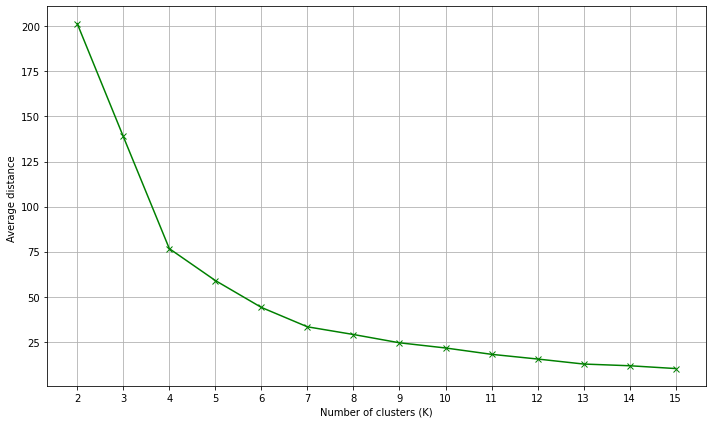

In [46]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(range(2,Ks),inertia,'gx-')
plt.ylabel('Average distance ')
plt.xlabel('Number of clusters (K)')
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
#plt.scatter(8, inertia[7], marker='o', color='g', s=100)
#bbox_props = dict(boxstyle="larrow,pad=0.6", fc="white", ec="g", lw=2)
#t = ax.text(11, 20, "Elbow point (K = 8)", ha="center", va="center", rotation=37,
#            size=15,
#            bbox=bbox_props)
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
# set number of clusters
kclusters = 4

# run k-means clustering 
#kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(neighborhood_clustering)
kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(scaled_sales)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 3, 3, 1, 1, 1, 3], dtype=int32)

In [48]:
df_cluster_shops.insert(0, 'shop_cluster', kmeans.labels_)
df_cluster_shops = df_cluster_shops[['shop_id', 'shop_cluster']].set_index('shop_id')
df_cluster_shops.head()

,shop_cluster
shop_id,
2,1
3,1
4,1
5,1
6,3


In [49]:
shop_clusters = {}

def get_shop_cluster(shop_id):
    if shop_id not in shop_clusters:
        shop_clusters[shop_id] = df_cluster_shops.loc[shop_id]['shop_cluster']
    return shop_clusters[shop_id]

### Cluster analysis for cities

In [50]:
#df_sales_items = df_sales.groupby(['date_block_num','shop_id'])['item_cnt_day'].sum().reset_index()
#df_sales_items['month'] = df_sales_items['date_block_num'] % 12 + 1
df_sales_items['city'] = df_sales_items['shop_id'].apply(lambda x: get_shop_city(x))
df_sales_items.head()

,date_block_num,shop_id,item_cnt_day,month,city
0,0,2,1146.00000,1,Адыгея
1,0,3,767.00000,1,Балашиха
2,0,4,2114.00000,1,Волжский
3,0,6,3686.00000,1,Воронеж
4,0,7,2495.00000,1,Воронеж


In [51]:
# for clustrer analysis
df_cluster_sales = df_sales_items.groupby(['month','city'])['item_cnt_day'].mean().to_frame(name='item_cnt_month').reset_index()
df_cluster_sales.head(10)

,month,city,item_cnt_month
0,1,Адыгея,1007.66667
1,1,Балашиха,904.00000
2,1,Волжский,1577.33333
3,1,Вологда,1521.50000
4,1,Воронеж,2489.85714
5,1,Жуковский,782.33333
6,1,Интернет,1592.33333
7,1,Казань,1316.00000
8,1,Калуга,2410.00000
9,1,Коломна,2196.33333


In [52]:
# for clustrer analysis
df_cluster_cities = df_cluster_sales.pivot_table(index=['city'], columns=['month'], values=['item_cnt_month'], fill_value=0)
df_cluster_cities.reset_index(inplace=True)
df_cluster_cities.columns = [ ''.join((name, str(date))) for (name, date) in df_cluster_cities.columns.values]
df_cluster_cities.head()

,city,item_cnt_month1,item_cnt_month2,item_cnt_month3,item_cnt_month4,item_cnt_month5,item_cnt_month6,item_cnt_month7,item_cnt_month8,item_cnt_month9,item_cnt_month10,item_cnt_month11,item_cnt_month12
0,Адыгея,1007.66667,768.66667,835.00000,744.33333,768.66667,864.33333,810.00000,924.33333,895.66667,822.33333,1027.00000,1621.50000
1,Балашиха,904.00000,803.00000,935.00000,690.66667,739.00000,761.33333,671.33333,819.33333,910.33333,737.00000,1016.50000,1204.50000
2,Волжский,1577.33333,1434.66667,1428.00000,779.66667,1142.66667,1156.66667,1103.66667,1349.00000,1119.33333,1164.33333,1428.50000,2159.50000
3,Вологда,1521.50000,1076.66667,1311.66667,1039.00000,1109.33333,1224.33333,1220.00000,1446.66667,1248.33333,1168.66667,1417.50000,2175.00000
4,Воронеж,2489.85714,2476.85714,2357.71429,1826.00000,1988.16667,2223.16667,2078.00000,2274.50000,2381.83333,2188.50000,2913.25000,4157.75000


In [53]:
#cluster analysis
from sklearn.preprocessing import StandardScaler
df_cluster_without_cities = df_cluster_cities.drop('city', axis=1)
scaled_sales = StandardScaler().fit_transform(df_cluster_without_cities.values)
scaled_sales.shape

(31, 12)

In [54]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

SEED = 579

#neighborhood_clustering = df_neighborhood_categories.drop('Neighborhood', axis=1)

# set number of clusters
Ks = 16
inertia = np.zeros((Ks-2))
for n in range(2,Ks):
    
    #Train Model and Predict  
    kmeans = KMeans(init='k-means++', n_clusters=n, random_state=SEED, algorithm="full").fit(scaled_sales)
    inertia[n-2] = kmeans.inertia_
inertia

array([155.69515854,  88.57575893,  53.1909822 ,  31.13420766,
        18.26961252,  13.15250172,  10.05189243,   7.95945857,
         6.32516435,   5.05445662,   4.07357843,   3.29410202,
         2.84431957,   2.38059402])

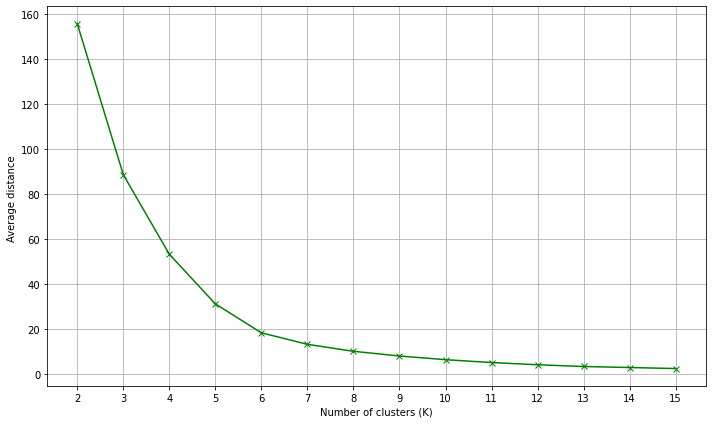

In [55]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(range(2,Ks),inertia,'gx-')
plt.ylabel('Average distance ')
plt.xlabel('Number of clusters (K)')
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
#plt.scatter(8, inertia[7], marker='o', color='g', s=100)
#bbox_props = dict(boxstyle="larrow,pad=0.6", fc="white", ec="g", lw=2)
#t = ax.text(11, 20, "Elbow point (K = 8)", ha="center", va="center", rotation=37,
#            size=15,
#            bbox=bbox_props)
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
# set number of clusters
kclusters = 6

# run k-means clustering 
#kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(neighborhood_clustering)
kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(scaled_sales)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 3, 3, 4, 5, 0, 4, 3, 4], dtype=int32)

In [57]:
df_cluster_cities.insert(0, 'city_cluster', kmeans.labels_)
df_cluster_cities = df_cluster_cities[['city', 'city_cluster']].set_index('city')
df_cluster_cities.head(10)

,city_cluster
city,
Адыгея,0
Балашиха,0
Волжский,3
Вологда,3
Воронеж,4
Выездная,5
Жуковский,0
Интернет,4
Казань,3


In [58]:
city_clusters = {}

def get_city_cluster(city):
    if city not in city_clusters:
        city_clusters[city] = df_cluster_cities.loc[city]['city_cluster']
    return city_clusters[city]

## Cluster analysis for categories

In [59]:
df_sales_items = df_sales.groupby(['date_block_num','shop_id', 'category'])['item_cnt_day'].sum().reset_index()
df_sales_items['month'] = df_sales_items['date_block_num'] % 12 + 1
df_sales_items.head()

,date_block_num,shop_id,category,item_cnt_day,month
0,0,2,Аксессуары - PS3,25.00000,1
1,0,2,Аксессуары - PS4,9.00000,1
2,0,2,Аксессуары - PSP,10.00000,1
3,0,2,Аксессуары - PSVita,10.00000,1
4,0,2,Аксессуары - XBOX 360,12.00000,1


In [60]:
# for clustrer analysis
df_cluster_sales = df_sales.groupby(['month','category'])['item_cnt_day'].mean().to_frame(name='item_cnt_month').reset_index()
df_cluster_sales.head(10)

,month,category,item_cnt_month
0,1,PC - Гарнитуры/Наушники,1.00000
1,1,Аксессуары - PS2,1.00000
2,1,Аксессуары - PS3,2.35665
3,1,Аксессуары - PS4,3.59714
4,1,Аксессуары - PSP,1.85938
5,1,Аксессуары - PSVita,1.69014
6,1,Аксессуары - XBOX 360,2.93394
7,1,Аксессуары - XBOX ONE,2.46718
8,1,Доставка товара,48.37500
9,1,Игровые консоли - PS3,2.19495


In [61]:
# for clustrer analysis
df_cluster_categories = df_cluster_sales.pivot_table(index=['category'], columns=['month'], values=['item_cnt_month'], fill_value=0)
df_cluster_categories.reset_index(inplace=True)
df_cluster_categories.columns = [ ''.join((name, str(date))) for (name, date) in df_cluster_categories.columns.values]
df_cluster_categories.head()

,category,item_cnt_month1,item_cnt_month2,item_cnt_month3,item_cnt_month4,item_cnt_month5,item_cnt_month6,item_cnt_month7,item_cnt_month8,item_cnt_month9,item_cnt_month10,item_cnt_month11,item_cnt_month12
0,PC - Гарнитуры/Наушники,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,Аксессуары - PS2,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,Аксессуары - PS3,2.35665,1.96922,1.78645,1.55399,1.51469,1.53602,1.53399,1.56831,1.54887,1.56675,1.73292,2.84758
3,Аксессуары - PS4,3.59714,3.85932,2.96505,2.56667,2.37792,2.50641,2.64142,2.71792,3.00764,2.80589,3.08746,5.35588
4,Аксессуары - PSP,1.85938,1.86111,1.85714,1.64167,1.52778,1.75000,1.84426,1.85263,1.64615,1.58904,1.87755,1.65000


In [62]:
#cluster analysis
from sklearn.preprocessing import StandardScaler
df_cluster_without_categories = df_cluster_categories.drop('category', axis=1)
scaled_sales = StandardScaler().fit_transform(df_cluster_without_categories.values)
scaled_sales.shape

(84, 12)

In [63]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

SEED = 579

#neighborhood_clustering = df_neighborhood_categories.drop('Neighborhood', axis=1)

# set number of clusters
Ks = 16
inertia = np.zeros((Ks-2))
for n in range(2,Ks):
    
    #Train Model and Predict  
    kmeans = KMeans(init='k-means++', n_clusters=n, random_state=SEED, algorithm="full").fit(scaled_sales)
    inertia[n-2] = kmeans.inertia_
inertia

array([174.38291586,  86.98851414,  44.79922857,  17.85800957,
         9.55633198,   6.4163758 ,   3.90717746,   3.06550487,
         2.55147792,   2.14484346,   1.65362508,   1.28144406,
         0.99991063,   0.83966163])

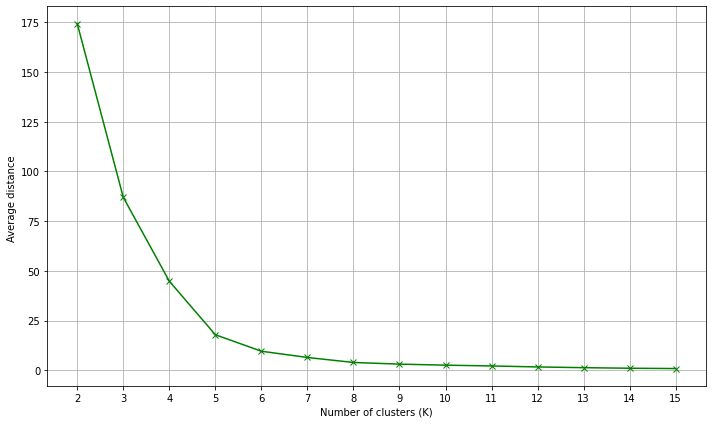

In [64]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(range(2,Ks),inertia,'gx-')
plt.ylabel('Average distance ')
plt.xlabel('Number of clusters (K)')
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
#plt.scatter(8, inertia[7], marker='o', color='g', s=100)
#bbox_props = dict(boxstyle="larrow,pad=0.6", fc="white", ec="g", lw=2)
#t = ax.text(11, 20, "Elbow point (K = 8)", ha="center", va="center", rotation=37,
#            size=15,
#            bbox=bbox_props)
plt.grid(True)
plt.tight_layout()
plt.show()

In [65]:
# set number of clusters
kclusters = 5

# run k-means clustering 
#kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(neighborhood_clustering)
kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(scaled_sales)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 4, 3], dtype=int32)

In [66]:
df_cluster_categories.insert(0, 'category_cluster', kmeans.labels_)
df_cluster_categories = df_cluster_categories[['category', 'category_cluster']].set_index('category')
df_cluster_categories.head()

,category_cluster
category,
PC - Гарнитуры/Наушники,0
Аксессуары - PS2,0
Аксессуары - PS3,0
Аксессуары - PS4,0
Аксессуары - PSP,0


In [67]:
category_clusters = {}

def get_category_cluster(category):
    if category not in category_clusters:
        category_clusters[category] = df_cluster_categories.loc[category]['category_cluster']
    return category_clusters[category]

## Model

In [68]:
#df_monthly_sales = df_sales.groupby(['date_block_num','shop_id','item_id'])[['item_cnt_day', 'revenue']].sum().reset_index()#.to_frame(name='item_cnt_month').reset_index()
#df_monthly_sales = df_sales.groupby(['date_block_num','shop_id','item_id'])['item_cnt_day'].sum().to_frame(name='item_cnt_month').reset_index()
df_monthly_sales = df_sales.copy()
#df_monthly_sales['shop_id'] = df_monthly_sales['shop_id'].apply(lambda x: valid_shop_id(x))
df_monthly_sales.head(10)

,date_block_num,shop_id,item_id,item_cnt_day,revenue,shop_type,category,city,month
0,0,2,27,1.00000,2499.00000,ТЦ,Игры - PS3,Адыгея,1
1,0,2,33,1.00000,499.00000,ТЦ,Кино - Blu-Ray,Адыгея,1
2,0,2,317,1.00000,299.00000,ТЦ,Книги - Аудиокниги 1С,Адыгея,1
3,0,2,438,1.00000,299.00000,ТЦ,Книги - Аудиокниги 1С,Адыгея,1
4,0,2,471,2.00000,798.00000,ТЦ,Книги - Методические материалы 1С,Адыгея,1
5,0,2,481,1.00000,330.00000,ТЦ,Книги - Методические материалы 1С,Адыгея,1
6,0,2,482,1.00000,3300.00000,ТЦ,Программы - 1С:Предприятие 8,Адыгея,1
7,0,2,484,2.00000,600.00000,ТЦ,Программы - 1С:Предприятие 8,Адыгея,1
8,0,2,491,1.00000,600.00000,ТЦ,Программы - 1С:Предприятие 8,Адыгея,1
9,0,2,534,2.00000,798.00000,ТЦ,Программы - Обучающие,Адыгея,1


In [69]:
df_monthly_sales.loc[(df_monthly_sales['date_block_num']==0) & (df_monthly_sales['item_id'] == 2552) & (df_monthly_sales['shop_id'] == 25)]

,date_block_num,shop_id,item_id,item_cnt_day,revenue,shop_type,category,city,month
19545,0,25,2552,0.00000,0.00000,ТРК,Музыка - Винил,Москва,1


In [70]:
# clip all cnt
#df_monthly_sales['item_cnt_day'] = np.clip(df_monthly_sales['item_cnt_day'], 0, 20)

In [71]:
df_monthly_sales.describe()

,date_block_num,shop_id,item_id,item_cnt_day,revenue,month
count,1608272.00000,1608272.00000,1608272.00000,1608272.00000,1608272.00000,1608272.00000
mean,14.66207,33.08813,10680.81598,2.26840,2113.40267,6.15391
std,9.54382,16.47024,6238.71724,8.65779,15321.22651,3.45497
min,0.00000,2.00000,0.00000,-22.00000,-33787.00000,1.00000
25%,6.00000,21.00000,5046.00000,1.00000,249.00000,3.00000
50%,14.00000,31.00000,10497.00000,1.00000,537.00000,6.00000
75%,23.00000,48.00000,16060.00000,2.00000,1490.00000,9.00000
max,33.00000,59.00000,22169.00000,2253.00000,6264230.00000,12.00000


In [72]:
df = df_monthly_sales.pivot_table(index=['shop_id','item_id'], columns=['date_block_num'], values='item_cnt_day', fill_value=0)
#df = df_monthly_sales.pivot_table(index=['shop_id','item_id'], columns=['date_block_num'], values=['item_cnt_day', 'revenue'], fill_value=0)
df.reset_index(inplace=True)
df.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,27,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,30,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,31,0,4,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,32,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,2,33,1,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,1,0


In [73]:
#df.columns = [ ''.join((name, str(date))) for (name, date) in df.columns.values]
#df['item_cnt_day34'] = np.nan
#df['revenue34'] = np.nan
df[34] = np.nan
df.describe()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,25,26,27,28,29,30,31,32,33,34
count,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,...,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,0.00000
mean,31.96317,11458.02437,0.31437,0.30627,0.35182,0.25630,0.25577,0.29979,0.27967,0.29958,...,0.20132,0.19610,0.18609,0.17286,0.15330,0.15108,0.15800,0.17417,0.16990,nan
std,16.70215,6133.50254,1.52184,1.61007,2.06599,1.36924,2.02436,3.34233,2.75611,2.93574,...,1.53860,1.50277,3.60501,2.86066,1.71125,1.58824,1.60870,4.95418,4.03456,nan
min,2.00000,0.00000,-13.00000,-4.00000,-2.00000,-2.00000,-1.00000,-1.00000,-2.00000,-2.00000,...,-1.00000,-2.00000,-1.00000,-1.00000,-1.00000,-1.00000,-2.00000,-1.00000,-1.00000,nan
25%,18.00000,6246.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan
50%,30.00000,11614.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan
75%,47.00000,16662.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan
max,59.00000,22169.00000,169.00000,130.00000,259.00000,175.00000,504.00000,766.00000,799.00000,820.00000,...,300.00000,291.00000,1242.00000,742.00000,444.00000,482.00000,436.00000,1644.00000,2253.00000,nan


In [74]:
# calc prev month
df['prev0'] = np.nan
df['prev_diff0'] = np.nan
df['mean3_0'] = np.nan
df['mean6_0'] = np.nan
#df_test['prev_year0'] = np.nan
#df_test['revenue_prev0'] = np.nan
#df_test['revenue_prev_diff0'] = np.nan
#df_test['revenue_prev_year0'] = np.nan
for col in range(1, 35):
    df[''.join(('prev', str(col)))] = df[col-1]
    df[''.join(('prev_diff', str(col)))] = df[col] - df[col-1]
    df[''.join(('mean3_', str(col)))] = np.nan
    
    if col > 2:
        df[''.join(('mean3_', str(col)))] = (df[col-1] + df[col-2] + df[col-3])/3
    
    df[''.join(('mean6_', str(col)))] = np.nan
    if col > 5:
        df[''.join(('mean6_', str(col)))] = (df[col-1] + df[col-2] + df[col-3] + df[col-4] + df[col-5] + df[col-6])/6
        
#    df_test[''.join(('revenue_prev_year', str(col)))] = np.nan
#    df_test[''.join(('prev_year', str(col)))] = np.nan
#    if col > 11:
#        df_test[''.join(('prev_year', str(col)))] = df_test[col-12]
#        df_test[''.join(('revenue_prev_year', str(col)))] = df_test[''.join(('revenue', str(col-12)))]
#    df_test[''.join(('revenue_prev', str(col)))] = df_test[''.join(('revenue', str(col-1)))]
#    df_test[''.join(('revenue_prev_diff', str(col)))] = df_test[''.join(('revenue_prev', str(col)))] - df_test[''.join(('revenue_prev', str(col-1)))]
        
df.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,mean3_32,mean6_32,prev33,prev_diff33,mean3_33,mean6_33,prev34,prev_diff34,mean3_34,mean6_34
0,2,27,1,0,0,0,0,0,0,0,...,0.00000,0.00000,0,0,0.00000,0.00000,0,nan,0.00000,0.00000
1,2,30,0,0,1,0,0,1,0,0,...,0.00000,0.00000,0,0,0.00000,0.00000,0,nan,0.00000,0.00000
2,2,31,0,4,1,1,0,0,0,0,...,0.00000,0.00000,0,1,0.00000,0.00000,1,nan,0.33333,0.16667
3,2,32,0,0,0,0,0,0,0,0,...,0.33333,0.33333,0,0,0.33333,0.16667,0,nan,0.33333,0.16667
4,2,33,1,0,0,0,0,0,0,0,...,0.33333,0.50000,1,-1,0.66667,0.66667,0,nan,0.33333,0.50000


In [75]:
# calc quarts
for col in range(2, 35):
    if (col+1)%3 == 0:
        q = (col+1)//3
        df[''.join(('Q', str(q)))] = df[col] + df[col-1] + df[col-2]
        #df_test[''.join(('revenueQ', str(q)))] = df_test[''.join(('revenue', str(col)))] + df_test[''.join(('revenue', str(col-1)))] + df_test[''.join(('revenue', str(col-2)))]
df.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11
0,2,27,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2,30,0,0,1,0,0,1,0,0,...,1,0,0,0,2,0,0,0,0,0
2,2,31,0,4,1,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,2,32,0,0,0,0,0,0,0,0,...,0,0,0,2,0,3,4,1,0,1
4,2,33,1,0,0,0,0,0,0,0,...,0,0,3,1,0,1,0,1,2,2


In [76]:
#df_test[[''.join(('itemQ', str(q))) for q in range(1,12)]].describe()
df[[''.join(('prev_diff', str(q))) for q in range(35)]].describe()

date_block_num,prev_diff0,prev_diff1,prev_diff2,prev_diff3,prev_diff4,prev_diff5,prev_diff6,prev_diff7,prev_diff8,prev_diff9,...,prev_diff25,prev_diff26,prev_diff27,prev_diff28,prev_diff29,prev_diff30,prev_diff31,prev_diff32,prev_diff33,prev_diff34
count,0.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,...,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,0.00000
mean,nan,-0.00810,0.04555,-0.09553,-0.00053,0.04402,-0.02012,0.01991,0.01923,-0.01385,...,-0.06402,-0.00522,-0.01001,-0.01323,-0.01956,-0.00222,0.00691,0.01617,-0.00427,nan
std,nan,1.56898,2.02822,1.81659,1.98818,2.52818,1.64871,1.65958,2.96289,2.63597,...,3.33092,1.42996,3.55927,3.61362,2.10240,0.85882,0.95541,4.51431,5.78411,nan
min,nan,-146.00000,-86.00000,-205.00000,-110.00000,-129.00000,-462.00000,-267.00000,-278.00000,-353.00000,...,-1122.00000,-300.00000,-212.00000,-1240.00000,-540.00000,-108.00000,-128.00000,-102.00000,-1644.00000,nan
25%,nan,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan
50%,nan,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan
75%,nan,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan
max,nan,127.00000,259.00000,175.00000,497.00000,683.00000,255.00000,375.00000,548.00000,305.00000,...,126.00000,286.00000,1242.00000,550.00000,109.00000,62.00000,144.00000,1625.00000,2007.00000,nan


In [77]:
df.columns.values

array(['shop_id', 'item_id', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 'prev0', 'prev_diff0', 'mean3_0', 'mean6_0',
       'prev1', 'prev_diff1', 'mean3_1', 'mean6_1', 'prev2', 'prev_diff2',
       'mean3_2', 'mean6_2', 'prev3', 'prev_diff3', 'mean3_3', 'mean6_3',
       'prev4', 'prev_diff4', 'mean3_4', 'mean6_4', 'prev5', 'prev_diff5',
       'mean3_5', 'mean6_5', 'prev6', 'prev_diff6', 'mean3_6', 'mean6_6',
       'prev7', 'prev_diff7', 'mean3_7', 'mean6_7', 'prev8', 'prev_diff8',
       'mean3_8', 'mean6_8', 'prev9', 'prev_diff9', 'mean3_9', 'mean6_9',
       'prev10', 'prev_diff10', 'mean3_10', 'mean6_10', 'prev11',
       'prev_diff11', 'mean3_11', 'mean6_11', 'prev12', 'prev_diff12',
       'mean3_12', 'mean6_12', 'prev13', 'prev_diff13', 'mean3_13',
       'mean6_13', 'prev14', 'prev_diff14', 'mean3_14', 'mean6_14',
       'prev15', 'prev_diff15', 'mean3_15', 'mean6_15', 'prev1

In [78]:
df.describe()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11
count,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,...,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000
mean,31.96317,11458.02437,0.31437,0.30627,0.35182,0.25630,0.25577,0.29979,0.27967,0.29958,...,0.81186,0.89805,1.05420,0.81746,0.69765,0.70108,0.94213,0.66276,0.51225,0.48325
std,16.70215,6133.50254,1.52184,1.61007,2.06599,1.36924,2.02436,3.34233,2.75611,2.93574,...,5.45541,8.71877,10.76105,7.93057,6.82260,7.00860,10.40647,5.65313,6.71217,6.77494
min,2.00000,0.00000,-13.00000,-4.00000,-2.00000,-2.00000,-1.00000,-1.00000,-2.00000,-2.00000,...,-2.00000,-2.00000,-21.00000,-2.00000,-2.00000,-5.00000,-1.00000,-2.00000,-2.00000,-2.00000
25%,18.00000,6246.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,30.00000,11614.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,47.00000,16662.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
max,59.00000,22169.00000,169.00000,130.00000,259.00000,175.00000,504.00000,766.00000,799.00000,820.00000,...,1160.00000,2569.00000,3272.00000,2616.00000,1824.00000,1758.00000,2615.00000,1423.00000,1418.00000,1675.00000


In [79]:
%%time
df['shop_type'] = df['shop_id'].apply(lambda x: get_shop_type(x))

CPU times: user 243 ms, sys: 1.98 ms, total: 245 ms
Wall time: 243 ms


In [80]:
%%time
df['shop_mega'] = df['shop_id'].apply(lambda x: get_shop_megality(x))

CPU times: user 480 ms, sys: 4.95 ms, total: 485 ms
Wall time: 486 ms


In [81]:
%%time
df['shop_cluster'] = df['shop_id'].apply(lambda x: get_shop_cluster(x))

CPU times: user 461 ms, sys: 3.77 ms, total: 465 ms
Wall time: 467 ms


In [82]:
%%time
df['subcategory'] = df['item_id'].apply(lambda x: get_category(x))

CPU times: user 545 ms, sys: 3.94 ms, total: 549 ms
Wall time: 549 ms


In [83]:
%%time
df['digital'] = df['item_id'].apply(lambda x: get_category_digitality(x))

CPU times: user 786 ms, sys: 5.95 ms, total: 792 ms
Wall time: 795 ms


In [84]:
%%time
df['city'] = df['shop_id'].apply(lambda x: get_shop_city(x))

CPU times: user 240 ms, sys: 1.99 ms, total: 242 ms
Wall time: 241 ms


In [85]:
%%time
df['city_cluster'] = df['city'].apply(lambda x: get_city_cluster(x))

CPU times: user 463 ms, sys: 2.92 ms, total: 466 ms
Wall time: 468 ms


In [86]:
%%time
df['category_cluster'] = df['subcategory'].apply(lambda x: get_category_cluster(x))

CPU times: user 459 ms, sys: 2.98 ms, total: 462 ms
Wall time: 461 ms


In [87]:
df['category'] = df['subcategory'].str.split('[-(]', n=0).str[0].str.strip()

In [88]:
#%%time
#df_sells_in_month['month'] = df_sells_in_month['date_block_num']%12 + 1

In [89]:
# clip all
#df_sells_in_month['item_cnt_prev_month'] = np.clip(df_sells_in_month['item_cnt_prev_month'], 0, 20)
#df_sells_in_month['item_cnt_month'] = np.clip(df_sells_in_month['item_cnt_month'], 0, 20)

#df_sells_in_month['prev_itemQ'].describe()

In [90]:
df.tail()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,Q11,shop_type,shop_mega,shop_cluster,subcategory,digital,city,city_cluster,category_cluster,category
418221,59,22154,1,0,0,0,0,0,0,0,...,0,ТЦ,0,1,Кино - Blu-Ray,0,Ярославль,3,0,Кино
418222,59,22155,0,0,0,0,0,0,1,0,...,0,ТЦ,0,1,Кино - Blu-Ray,0,Ярославль,3,0,Кино
418223,59,22162,0,0,0,0,0,0,0,0,...,1,ТЦ,0,1,Кино - DVD,0,Ярославль,3,0,Кино
418224,59,22164,0,0,0,0,0,0,0,0,...,1,ТЦ,0,1,Кино - Blu-Ray,0,Ярославль,3,0,Кино
418225,59,22167,0,0,0,0,0,0,0,0,...,0,ТЦ,0,1,Книги - Методические материалы 1С,0,Ярославль,3,0,Книги


In [91]:
df.loc[df['digital'] == 1, 33].describe()

count   2093.00000
mean       0.94171
std        4.42145
min       -1.00000
25%        0.00000
50%        0.00000
75%        0.00000
max       82.00000
Name: 33, dtype: float64

In [92]:
df[item_labels.columns.values] = df['item_id'].apply(lambda x: get_items_features(x))

In [93]:
df.columns.values

array(['shop_id', 'item_id', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 'prev0', 'prev_diff0', 'mean3_0', 'mean6_0',
       'prev1', 'prev_diff1', 'mean3_1', 'mean6_1', 'prev2', 'prev_diff2',
       'mean3_2', 'mean6_2', 'prev3', 'prev_diff3', 'mean3_3', 'mean6_3',
       'prev4', 'prev_diff4', 'mean3_4', 'mean6_4', 'prev5', 'prev_diff5',
       'mean3_5', 'mean6_5', 'prev6', 'prev_diff6', 'mean3_6', 'mean6_6',
       'prev7', 'prev_diff7', 'mean3_7', 'mean6_7', 'prev8', 'prev_diff8',
       'mean3_8', 'mean6_8', 'prev9', 'prev_diff9', 'mean3_9', 'mean6_9',
       'prev10', 'prev_diff10', 'mean3_10', 'mean6_10', 'prev11',
       'prev_diff11', 'mean3_11', 'mean6_11', 'prev12', 'prev_diff12',
       'mean3_12', 'mean6_12', 'prev13', 'prev_diff13', 'mean3_13',
       'mean6_13', 'prev14', 'prev_diff14', 'mean3_14', 'mean6_14',
       'prev15', 'prev_diff15', 'mean3_15', 'mean6_15', 'prev1

In [94]:
df_test = pd.merge(df_test, df, on=['shop_id','item_id'], how='left')
df_test = df_test.fillna(0)
df_test.drop(['ID'], axis=1, inplace=True)
df_test.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,l0_русская документация,l0_kinect,l0_pc move,l0_ps4,l0_xbox one,l0_ps vita,l0_дополнение,l0_classics,l0_софтклаб,l0_1 год
0,5,5037,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,5,5320,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,5,5233,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,5,5232,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
4,5,5268,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [95]:
%%time
df_test['shop_type'] = df_test['shop_id'].apply(lambda x: get_shop_type(x))
df_test['shop_mega'] = df_test['shop_id'].apply(lambda x: get_shop_megality(x))
df_test['shop_cluster'] = df_test['shop_id'].apply(lambda x: get_shop_cluster(x))
df_test['subcategory'] = df_test['item_id'].apply(lambda x: get_category(x))
df_test['digital'] = df_test['item_id'].apply(lambda x: get_category_digitality(x))
df_test['city'] = df_test['shop_id'].apply(lambda x: get_shop_city(x))
df_test['city_cluster'] = df_test['city'].apply(lambda x: get_city_cluster(x))
df_test['category_cluster'] = df_test['subcategory'].apply(lambda x: get_category_cluster(x))
df_test['category'] = df_test['subcategory'].str.split('[-(]', n=0).str[0].str.strip()

CPU times: user 3.89 s, sys: 592 ms, total: 4.48 s
Wall time: 4.52 s


In [96]:
#const_cols = ['shop_cluster', 'city_cluster', 'category_cluster']
const_cols = ['shop_cluster', 'city_cluster', 'category_cluster', 'shop_type', 'subcategory', 'category', 'city', 'shop_mega', 'digital']
#const_cols = ['shop_type', 'subcategory', 'category', 'city', 'shop_mega', 'digital']
l12_cols = item_labels.columns.values
const_cols = np.concatenate([const_cols,l12_cols])
#const_cols = ['shop_id', 'item_id']
train_cols = [item for sublist in [[''.join(('prev', str(q)))
                       , ''.join(('prev_diff', str(q)))
                       , ''.join(('mean3_', str(q)))
                      , ''.join(('mean6_', str(q)))] 
                      for q in range(6, 33)] for item in sublist]
test_cols = [item for sublist in [[''.join(('prev', str(q)))
                       , ''.join(('prev_diff', str(q)))
                       , ''.join(('mean3_', str(q)))
                      , ''.join(('mean6_', str(q)))] 
                      for q in range(7, 34)] for item in sublist]
pred_cols = [item for sublist in [[''.join(('prev', str(q)))
                       , ''.join(('prev_diff', str(q)))
                       , ''.join(('mean3_', str(q)))
                      , ''.join(('mean6_', str(q)))] 
                      for q in range(8, 35)] for item in sublist]
X_const = df[const_cols]
X_const_pred = df_test[const_cols]
X_train_data = df[train_cols]
X_test_data = df[test_cols]
X_pred_data = df_test[pred_cols]
#Y_train = np.clip(df[32].values, 0, 20)
#Y_test = np.clip(df[33].values, 0, 20)
Y_train = df[32]
Y_test = df[33]
X_train_data.head()
#np.array([const_cols,test_cols]).flatten()
#const_cols + test_cols
#flat_list = const_cols + [item for sublist in test_cols for item in sublist]
#flat_list

date_block_num,prev6,prev_diff6,mean3_6,mean6_6,prev7,prev_diff7,mean3_7,mean6_7,prev8,prev_diff8,...,mean3_30,mean6_30,prev31,prev_diff31,mean3_31,mean6_31,prev32,prev_diff32,mean3_32,mean6_32
0,0,0,0.00000,0.16667,0,0,0.00000,0.00000,0,0,...,0.00000,0.00000,0,0,0.00000,0.00000,0,0,0.00000,0.00000
1,1,-1,0.33333,0.33333,0,0,0.33333,0.33333,0,0,...,0.00000,0.00000,0,0,0.00000,0.00000,0,0,0.00000,0.00000
2,0,0,0.33333,1.00000,0,0,0.00000,1.00000,0,0,...,0.00000,0.00000,0,0,0.00000,0.00000,0,0,0.00000,0.00000
3,0,0,0.00000,0.00000,0,0,0.00000,0.00000,0,0,...,0.00000,0.16667,0,1,0.00000,0.16667,1,-1,0.33333,0.33333
4,0,0,0.00000,0.16667,0,0,0.00000,0.00000,0,0,...,0.66667,0.50000,1,-1,0.66667,0.66667,0,1,0.33333,0.50000


In [97]:
const_cols

array(['shop_cluster', 'city_cluster', 'category_cluster', 'shop_type',
       'subcategory', 'category', 'city', 'shop_mega', 'digital', 'l0_pc',
       'l0_цифровая версия', 'l0_регион', 'l0_ps3', 'l0_русская версия',
       'l0_jewel', 'l0_xbox 360', 'l0_bd', 'l0_rem', 'l0_cd',
       'l0_digipack', 'l0_mp3', 'l0_dvd', 'l0_box',
       'l0_английская версия', 'l0_фирм', 'l0_3d', 'l0_русские субтитры',
       'l0_digibook', 'l0_essentials', 'l0_psp',
       'l0_русская документация', 'l0_kinect', 'l0_pc move', 'l0_ps4',
       'l0_xbox one', 'l0_ps vita', 'l0_дополнение', 'l0_classics',
       'l0_софтклаб', 'l0_1 год'], dtype=object)

In [98]:
df_test[[32,33]].describe()

,32,33
count,214200.00000,214200.00000
mean,0.27462,0.29341
std,2.49898,5.55098
min,-1.00000,-1.00000
25%,0.00000,0.00000
50%,0.00000,0.00000
75%,0.00000,0.00000
max,473.00000,2253.00000


In [99]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score

date_ix = 0

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes_names):
        self.attributes_names = attributes_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attributes_names].values # convert to NumPy array

class CycleTransformator( BaseEstimator, TransformerMixin):
    #Class Constructor 
    def __init__( self,  cycle_columns ):
        self._cycle_columns = cycle_columns
        self._cycle_stats = {}
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        for column in self._cycle_columns:
            self._cycle_stats[column] = { 'max': X[column].max(), 'min': X[column].min() }
        return self
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        self._df = pd.DataFrame(index=X.index)
        for column in self._cycle_columns:
            self._df[column+'_sin'] = np.sin(2*np.pi/(self._cycle_stats[column]['max']+1)*X[column].fillna(self._cycle_stats[column]['min']-1))
            self._df[column+'_cos'] = np.cos(2*np.pi/(self._cycle_stats[column]['max']+1)*X[column].fillna(self._cycle_stats[column]['min']-1))

        #self._df = self._df.reset_index(drop=True)
        #print('Cycle transform shape is {}'.format(self._df.values.shape))
        return self._df.values

In [100]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [101]:
from sklearn.metrics import make_scorer

def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

In [102]:
#num_attribs = ['item_cnt_prev_month','item_cnt_prev_diff','prev_itemQ','item_cnt_prev_year']
#num_attribs = ['prev_month','prev_diff', 'prev_itemQ', 'mean3', 'mean6']
num_attribs = l12_cols

#num_attribs = ['digital']
#cat_attribs = ['shop_cluster', 'category_cluster']
#cat_attribs = ['city_cluster','shop_cluster', 'category_cluster']
#cat_attribs = ['shop_type', 'category', 'city', 'shop_mega', 'digital']
#cat_attribs = ['shop_type', 'subcategory', 'category', 'city', 'shop_mega', 'digital']
#cat_attribs = ['shop_type', 'subcategory', 'category', 'city']
cat_attribs = ['city_cluster','shop_cluster', 'category_cluster', 'shop_type', 'category', 'city', 'shop_mega', 'digital']
#cat_attribs = ['city_cluster','shop_cluster', 'category_cluster', 'shop_type', 'subcategory', 'category', 'city', 'shop_mega', 'digital']
#cat_attribs = ['shop_type', 'category', 'city']
#cat_attribs = ['city_cluster','shop_cluster', 'category_cluster', 'shop_type', 'category']
#cat_attribs = ['shop_cluster', 'category']
#num_attribs = ['item_id','shop_id','digital']
#cat_attribs = ['category']
date_attribs = ['month']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy="median")),
#    ('std_scaler', StandardScaler()),
])
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(sparse=False, drop='first')),
])
counted_pipeline = Pipeline([
    ('cycle_transformator', CycleTransformator(cycle_columns=date_attribs)),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
#    ('counted_pipeline', counted_pipeline),
])

In [103]:
X_const.shape

(418226, 40)

In [104]:
X_const_pred.shape

(214200, 40)

In [105]:
#Y_test.describe()
X_const.head()

date_block_num,shop_cluster,city_cluster,category_cluster,shop_type,subcategory,category,city,shop_mega,digital,l0_pc,...,l0_русская документация,l0_kinect,l0_pc move,l0_ps4,l0_xbox one,l0_ps vita,l0_дополнение,l0_classics,l0_софтклаб,l0_1 год
0,1,0,0,ТЦ,Игры - PS3,Игры,Адыгея,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,ТЦ,Кино - DVD,Кино,Адыгея,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,ТЦ,Кино - Blu-Ray,Кино,Адыгея,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,ТЦ,Кино - DVD,Кино,Адыгея,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,ТЦ,Кино - Blu-Ray,Кино,Адыгея,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
X_prepared = full_pipeline.fit_transform(X_const)
X_prepared_pred = full_pipeline.transform(X_const_pred)
X_prepared.shape

(418226, 97)

In [107]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
#X_train = sc.fit_transform(X_train_data)
X_train = np.concatenate((X_prepared, X_train_data), axis=1)
#X_train = X_train_data
X_train.shape

(418226, 205)

In [108]:
#
#X_test = sc.transform(X_test_data)
#X_test = X_test_data
X_test = np.concatenate((X_prepared, X_test_data), axis=1)
X_test.shape

(418226, 205)

In [109]:
#X_pred = sc.transform(X_pred_data)
#X_pred = X_pred_data
X_pred = np.concatenate((X_prepared_pred, X_pred_data), axis=1)
X_pred.shape

(214200, 205)

In [110]:
#from sklearn.preprocessing import PolynomialFeatures

#poly = PolynomialFeatures(degree=2)
#X_train_prepared = poly.fit_transform(X_train_prepared)
#X_test_prepared = poly.transform(X_test_prepared)
#X_train_prepared.shape

In [111]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Std Deviation:", scores.std())

In [112]:
%%time

from sklearn.tree import DecisionTreeRegressor

# train
tree_reg = DecisionTreeRegressor(random_state=57)
tree_reg.fit(X_train, Y_train)

# predict
predictions = tree_reg.predict(X_train)

#scores = cross_val_score(tree_reg, X_train_prepared, Y_train, cv=tscv, scoring="r2")
#print('%s: %f (%f)' % ('Tree: ', scores.mean(), scores.std()))
#tree_rmse_scores = np.sqrt(-scores)
#display_scores(tree_rmse_scores)

print("R2-score: %.2f" % r2_score(Y_train, predictions) )

print('Testing...')
Y_pred = tree_reg.predict(X_test)
#Y_pred = np.clip(Y_pred, 0, 20)
print("R2-score: %.2f" % r2_score(Y_test, Y_pred) )
print("MSE: %.6f" % mean_squared_error(Y_test, Y_pred))
#regression_results(Y_pred , Y_test)

R2-score: 1.00
Testing...
R2-score: 0.58
MSE: 6.789418
CPU times: user 1min 14s, sys: 2.58 s, total: 1min 17s
Wall time: 1min 24s


In [113]:
%%time
from sklearn.linear_model import LinearRegression

# train
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)
# predict
predictions = lin_reg.predict(X_train)

#scores = cross_val_score(lin_reg, X_train, Y_train, cv=tscv, scoring="r2")
#print('%s: %f (%f)' % ('LinReg: ', scores.mean(), scores.std()))
#lin_rmse_scores = np.sqrt(-scores)
#display_scores(lin_rmse_scores)

print("R2-score: %.2f" % r2_score(Y_train, predictions) )

print('Testing...')
Y_pred = lin_reg.predict(X_test)
#Y_pred = np.clip(Y_pred, 0, 20)
print("R2-score: %.2f" % r2_score(Y_test, Y_pred) )
print("MSE: %.6f" % mean_squared_error(Y_test, Y_pred))
#regression_results(Y_test, Y_pred)

R2-score: 1.00
Testing...
R2-score: 1.00
MSE: 0.000000
CPU times: user 27 s, sys: 8.14 s, total: 35.2 s
Wall time: 25 s


In [114]:
%%time
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=250, random_state=57, n_jobs=4, verbose=1)
print('Fitting...')
forest_reg.fit(X_train, Y_train)
# predict
print('Predicting...')
predictions = forest_reg.predict(X_train)

#print('Cross validating...')
#scores = cross_val_score(forest_reg, X_train_prepared, Y_train, cv=tscv, scoring="r2", n_jobs=4, verbose=1)
#print('%s: %f (%f)' % ('Forest: ', scores.mean(), scores.std()))
#forest_rmse_scores = np.sqrt(-scores)
#display_scores(forest_rmse_scores)

print("R2-score: %.2f" % r2_score(Y_train, predictions) )

print('Testing...')
Y_pred = forest_reg.predict(X_test)
#Y_pred = np.clip(Y_pred, 0, 20)
print("R2-score: %.2f" % r2_score(Y_test, Y_pred) )
print("MSE: %.6f" % mean_squared_error(Y_test, Y_pred))

Fitting...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  6.6min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 29.4min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 38.2min finished


Predicting...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    4.8s finished


R2-score: 0.99
Testing...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.6s


R2-score: 0.84
MSE: 2.557138
CPU times: user 2h 27min 3s, sys: 6.85 s, total: 2h 27min 10s
Wall time: 38min 22s


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    4.8s finished


In [115]:
#feature_importances = 
#forest_reg.feature_importances_

In [116]:
'''
#cat_encoder = cat_pipeline.named_steps["cat_encoder"]
#cat_one_hot_attribs = list(cat_encoder.categories_[0]) + list(cat_encoder.categories_[1]) + list(cat_encoder.categories_[2])
counted_encoder = counted_pipeline.named_steps["cycle_transformator"]
counted_attribs = list(counted_encoder._df.columns)
#attributes = num_attribs + cat_one_hot_attribs + counted_attribs
attributes = num_attribs + counted_attribs
sorted(zip(feature_importances, attributes), reverse=True)
'''

'\n#cat_encoder = cat_pipeline.named_steps["cat_encoder"]\n#cat_one_hot_attribs = list(cat_encoder.categories_[0]) + list(cat_encoder.categories_[1]) + list(cat_encoder.categories_[2])\ncounted_encoder = counted_pipeline.named_steps["cycle_transformator"]\ncounted_attribs = list(counted_encoder._df.columns)\n#attributes = num_attribs + cat_one_hot_attribs + counted_attribs\nattributes = num_attribs + counted_attribs\nsorted(zip(feature_importances, attributes), reverse=True)\n'

In [117]:
%%time
# Lasso
from sklearn.linear_model import Lasso

alpha = 0.1
lasso = Lasso(alpha=alpha)

lasso.fit(X_train, Y_train)
# predict
predictions = lasso.predict(X_train)

#scores = cross_val_score(lasso, X_train, Y_train, cv=tscv, scoring="r2")
#print('%s: %f (%f)' % ('Lasso: ', scores.mean(), scores.std()))
#lin_rmse_scores = np.sqrt(-scores)
#display_scores(lin_rmse_scores)

print("R2-score: %.2f" % r2_score(Y_train, predictions) )

print('Testing...')
Y_pred = lasso.predict(X_test)
#Y_pred = np.clip(Y_pred, 0, 20)
print("R2-score: %.2f" % r2_score(Y_test, Y_pred) )
print("MSE: %.6f" % mean_squared_error(Y_test, Y_pred))

R2-score: 1.00
Testing...
R2-score: 1.00
MSE: 0.060640
CPU times: user 23.4 s, sys: 7.29 s, total: 30.7 s
Wall time: 16.5 s


In [118]:
%%time
# ElasticNet
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=alpha, l1_ratio=0.8)
enet.fit(X_train, Y_train)
# predict
predictions = enet.predict(X_train)

#scores = cross_val_score(enet, X_train_prepared, Y_train, cv=tscv, scoring="r2")
#print('%s: %f (%f)' % ('Enet: ', scores.mean(), scores.std()))
#lin_rmse_scores = np.sqrt(-scores)
#display_scores(lin_rmse_scores)

print("R2-score: %.2f" % r2_score(Y_train, predictions) )

print('Testing...')
Y_pred = enet.predict(X_test)
#Y_pred = np.clip(Y_pred, 0, 20)
print("R2-score: %.2f" % r2_score(Y_test, Y_pred) )
print("MSE: %.6f" % mean_squared_error(Y_test, Y_pred))

R2-score: 1.00
Testing...
R2-score: 1.00
MSE: 0.067900
CPU times: user 27.4 s, sys: 5.03 s, total: 32.5 s
Wall time: 12.8 s


In [119]:
#df_test['34_scaled'] = (20*(df_test[34] - np.min(df_test[34]))/np.ptp(df_test[34]))   
#df_test['34'] = np.clip(df_test[34], 0, 20)

In [123]:
#X_prepared = full_pipeline.transform(X_pred)
#
Y_pred = lasso.predict(X_pred)
#Y_pred = forest_reg.predict(X_pred)
#Y_pred = tree_reg.predict(X_pred)

In [124]:
df_submission = pd.read_csv('sample_submission.csv')
#df_submission['item_cnt_month'] = df_test['34_scaled']
#df_submission['item_cnt_month'] = np.clip(df_prediction['item_cnt_month'], 0, 20)
#df_submission['item_cnt_month'] = Y_pred
df_submission['item_cnt_month'] = np.clip(Y_pred, 0, 20)
#df_submission['item_cnt_month'] = Y_pred
df_submission.to_csv('submission104_12.csv', index=False)
df_submission.head()

,ID,item_cnt_month
0,0,0.00502
1,1,0.00502
2,2,0.95202
3,3,0.00502
4,4,0.00502


In [ ]:
df_submission['item_cnt_month'].describe()

In [ ]:
df_submission[df_submission['item_cnt_month']>0].count()

In [ ]:
print(df_test[df_test[32]>0].count())
df_test[32].describe()

submission104_1.csv
a few seconds ago by Andrey Vest

RandomForest, merge test, previous , cluster features
1.22073

submission104_6.csv
21 minutes ago by Andrey Vest

Tree, merge test, previous , all features - cluster features + item features
1.17881

submission104_7.csv
a few seconds ago by Andrey Vest

Lasso, merge test, previous , all features - cluster features + item features + stdScale
1.22322

submission104_11.csv
2 minutes ago by Andrey Vest

Forest, merge test, previous , all features - cluster features + item features, trained on full data
1.15678